In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,mean_squared_error, r2_score
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

df = pd.read_csv("sudata.csv")

# Convert column names to camelCase
colNames = [col.replace(" ", "").replace("_", "").replace("-", "").replace("(", "").replace(")", "") for col in df.columns]
colNames = [col[0].lower() + col[1:] if col else "" for col in colNames]
colNames = [colNames[i] if i == 0 else colNames[i][0].upper() + colNames[i][1:] for i in range(len(colNames))]

# Assign the new column names to the DataFrame
df.columns = colNames

print(df.columns.to_numpy())

df['ApplicationsRegisteredinCollege'] = df['ApplicationsRegisteredinColleague']

continuous_vars = ['RecordCreatedDate', 'ApplicationCreatedDate', 'DecisionsReleasedDate', 'TestsGMATTotal','GPAConverted', 'Age', 'Intendtoapplyforfinancialaid', 'ApplicationsRegisteredinCollege', 'ApplicationsScholarshipTierAdmit']
categorical_vars = ['ApplicationStatus', 'ApplicationProgram', 'ApplicationStartTerm', 'DecisionReason', 'Country', 'VisaType','Race', 'Sex']




# HANDLING MISSING VALUES

print('HANDLING MISSING VALUES\n')
# Finding number of missing values in each column
missing_counts = df.isna().sum()
print(missing_counts)




print('COUNTRY\n')

missing_counts = df['Country'].isna().sum()
print(missing_counts)

# Dropping because for this combination all other values are also missing
df = df.drop(df[((df['ApplicationStatus'] == 'Awaiting Submission') |
                 (df['ApplicationStatus'] == 'Awaiting Materials') |
                 (df['ApplicationStatus'] == 'Awaiting Decision')) & (df['DecisionReason'].isnull()) & (df['Country'].isnull())].index)
print("After dropping")
missing_counts = df['Country'].isna().sum()
print(missing_counts)

print(df.shape)

# Fill with some value 'Others'- later can group it into category
df['Country'].fillna('Others', inplace=True)

missing_counts = df['Country'].isna().sum()
print("After filling")
print(missing_counts)










print('VISA TYPE\n')

# Filter rows where 'VisaType' is blank (NaN)
blank_visa_rows = df[df['VisaType'].isna()]

# Get the unique 'Country' values from the filtered rows
unique_countries = blank_visa_rows['Country'].unique()

# Print the unique countries
print(unique_countries)


# Find the number of records where 'VisaType' is blank and 'Country' is 'United States'
us_blank_visa_count = df.loc[(df['VisaType'].isna()) & (df['Country'] == 'United States'), 'Country'].count()
print(f"Number of records where 'VisaType' is blank and 'Country' is 'United States': {us_blank_visa_count}")

# Finding number of missing values in each column
missing_counts = df['VisaType'].isna().sum()
print(missing_counts)

# Fill 'VisaType' with 'NA  Not Applicable' where 'Country' is 'United States' and 'VisaType' is blank
df.loc[(df['VisaType'].isna()) & (df['Country'] == 'United States'), 'VisaType'] = 'Domestic'

# Finding number of missing values in each column
missing_counts = df['VisaType'].isna().sum()
print("After filling")
print(missing_counts)

# Dropping because for this combination all other values are also missing
df = df.drop(df[((df['ApplicationStatus'] == 'Awaiting Submission') |
                 (df['ApplicationStatus'] == 'Awaiting Materials') |
                 (df['ApplicationStatus'] == 'Awaiting Decision')) & (df['DecisionReason'].isnull()) & (df['VisaType'].isnull())].index)


# Finding number of missing values in each column
missing_counts = df['VisaType'].isna().sum()
print("After dropping")
print(missing_counts)

df['VisaType'].fillna('Other', inplace=True)

# Finding number of missing values in each column
missing_counts = df['VisaType'].isna().sum()
print("After filling")
print(missing_counts)











print('GPA CONVERTED\n')


df = df[df['GPARecalculated'] != 99]  #This is exceptional case in data - so dropping

# Conditionally fill 'GPAConverted' with 'GPARecalculated' where 'GPAConverted' is blank and 'GPARecalculated' is not null
df.loc[df['GPAConverted'].isnull() & df['GPARecalculated'].notnull(), 'GPAConverted'] = df['GPARecalculated']
missing_counts = df['GPAConverted'].isna().sum()
print("After filling")
print(missing_counts)
print(df.shape)

# Dropping because for this combination all other values are also missing
df = df.drop(df[((df['ApplicationStatus'] == 'Awaiting Submission') |
                 (df['ApplicationStatus'] == 'Awaiting Materials') |
                 (df['ApplicationStatus'] == 'Awaiting Decision')) &
                (df['DecisionReason'].isnull()) &
                (df['GPAConverted'].isnull())].index)
missing_counts = df['GPAConverted'].isna().sum()
print("After dropping")
print(missing_counts)

# Calculate the average of non-null values in 'GPAConverted'
average_gpa_converted = df['GPAConverted'].mean()


print('average_gpa_converted',average_gpa_converted)
# Fill blank values in 'GPAConverted' with the calculated average
df['GPAConverted'].fillna(average_gpa_converted, inplace=True)

missing_counts = df['GPAConverted'].isna().sum()
print("After filling")
print(missing_counts)











print('DECISION RELEASED DATE\n')


# Convert dates in the first format
df['ApplicationCreatedDate'] = pd.to_datetime(df['ApplicationCreatedDate'], infer_datetime_format=True)
df['DecisionsReleasedDate'] = pd.to_datetime(df['DecisionsReleasedDate'], infer_datetime_format=True, errors='coerce')

# Calculate the time differences
df['DecisionDelayPeriod'] = df['DecisionsReleasedDate'] - df['ApplicationCreatedDate']

# Calculate the average of non-null time differences
average_time_difference = df.loc[df['DecisionDelayPeriod'].notnull(), 'DecisionDelayPeriod'].mean()


print("average_time_difference",average_time_difference)
# Fill NaN values in 'DecisionsReleasedDate' with the calculated average
df['DecisionsReleasedDate'].fillna(df['ApplicationCreatedDate'] + average_time_difference, inplace=True)


missing_counts = df['DecisionsReleasedDate'].isna().sum()
print("After filling")
print(missing_counts,'\n')




df['DecisionDelayPeriod'] = df['DecisionsReleasedDate'] - df['ApplicationCreatedDate']

df['DecisionDelayPeriod'] = df['DecisionDelayPeriod'].astype(str)

# Preprocess the DecisionDelayPeriod column to extract the number of days
df['DecisionDelayDays'] = df['DecisionDelayPeriod'].str.extract('(\d+)').astype(float)




print('DECISION REASON\n')



df['DecisionReason'].fillna('Other Reason', inplace=True)

# Print the value counts of 'DecisionReason' according to the custom order
print(df['DecisionReason'].value_counts(dropna=False))

missing_counts = df['DecisionReason'].isna().sum()
print("After filling")
print(missing_counts)







print('SCHOLARSHIP TIER\n')


df['ApplicationsScholarshipTierAdmit'].fillna('No Scholarship', inplace=True)

missing_counts = df['ApplicationsScholarshipTierAdmit'].isna().sum()
print("After filling")
print(missing_counts)





print('DROPPING IRRELEVANT COLUMNS\n')


# Dropping unnecessary columns
to_be_dropped_columns = ['GPARecalculated','State','PreviousDegreeInsitution','ApplicationReferralSource']
# df = df.drop(to_be_dropped_columns, axis=1)


# SUMMARY STATISTICS
print('SUMMARY STATISTICS')
print(df[continuous_vars].describe())

print('CORRELATION MATRIX')
print(df[continuous_vars].corr())



# FINDING UNIQUE VALUE COUNTS IN EACH COLUMN FOR THE PURPOSE OF CATEGORISATION OF VARIABLES

for col in categorical_vars:
    print(f"Unique value counts for column '{col}':")
    print(df[col].value_counts(dropna=False))
    print()  # Print an empty line for better readability

# CATEGORISING VARIABLES

df['CountryUS'] = np.where(df['Country'] == "United States", 1,0)

df['VisaRequired'] = np.where((df['VisaType'] == "Domestic") | (df['VisaType'] == "NA  Not Applicable"), 0, 1)

df['ApplicationStatusDecided'] = np.where(df['ApplicationStatus'] == "Decided", 1,0)
df['Scholarship(Yes)'] = np.where(df['ApplicationsScholarshipTierAdmit'] == "No Scholarship", 0,1)


df['Sex(Male)'] = np.where(df['Sex'] == "M", 1, 0)



print('APPLICATION PROGRAM')

# Create a dictionary mapping each category to its corresponding group 
# category_groups = {
#     'Business Analytics - MSBA': 'MSBA',
#     'Finance - MSF': 'MSF',
#     'Business Analytics with Finance degrees - MSBA/MSF': 'JointPrograms(MSBA/MSF|MSBL/JD|MBA/JD)',
#     'Business Administration (Professional) - MBA': 'MBA',
#     'Sport and Entertainment Management - MBA': 'MBASportsLeadership',
#     'Leadership Executive Master of Business Administration - MBA': 'MBASportsLeadership',
#     'Business Administration (Professional) - MBA - Online Instruction': 'MBAOnline',
#     'Business Analytics - MSBA - Online Instruction': 'MSBAOnline',
#     'Business Administration - Bridge - MBA': 'MBAOthers',
#     'Early Career Masters of Business Administration': 'MBAOthers',
#     'Sport Business Leadership- MSBL': 'MBASportsLeadership',
#     'Sport Business Leadership, joint Juris Doctor - MSBL/JD': 'JointPrograms(MSBA/MSF|MSBL/JD|MBA/JD)',
#     'Business Administration (Professional), joint Juris Doctor - MBA/JD': 'JointPrograms(MSBA/MSF|MSBL/JD|MBA/JD)',
#     'Accounting and Analytics - MS': 'MSMPAC',
#     'Accounting (Professional) - MPAC Advanced': 'MSMPAC',
#     'Accounting (Professional) - MPAC': 'MSMPAC',
#     'Non-Matriculated status - Albers School of Business and Economics': 'CertificatePrograms',
#     'Business Analytics Certificate': 'CertificatePrograms',
#     'Executive Leadership Certificate': 'CertificatePrograms',
#     'Leadership Formation Certificate': 'CertificatePrograms',
#     'Marketing Certificate': 'CertificatePrograms',
#     'Business Administration Certificate': 'CertificatePrograms',
#     'Global Business Certificate': 'CertificatePrograms',
#     'Finance Certificate': 'CertificatePrograms',
#     'Accounting Certificate': 'CertificatePrograms'
# }


category_groups = {
    'Business Analytics - MSBA': 'MSBA',
    'Finance - MSF': 'Finance',
    'Business Analytics with Finance degrees - MSBA/MSF': 'JointDegrees/CertificatePrograms',
    'Business Administration (Professional) - MBA': 'MBA',
    'Sport and Entertainment Management - MBA': 'MBAOthers',
    'Leadership Executive Master of Business Administration - MBA': 'MBAOthers',
    'Business Administration (Professional) - MBA - Online Instruction': 'MBA/MSBAOnline',
    'Business Analytics - MSBA - Online Instruction': 'MBA/MSBAOnline',
    'Business Administration - Bridge - MBA': 'MBAOthers',
    'Early Career Masters of Business Administration': 'MBAOthers',
    'Sport Business Leadership- MSBL': 'MBAOthers',
    'Sport Business Leadership, joint Juris Doctor - MSBL/JD': 'JointDegrees/CertificatePrograms',
    'Business Administration (Professional), joint Juris Doctor - MBA/JD': 'JointDegrees/CertificatePrograms',
    'Accounting and Analytics - MS': 'Accounting',
    'Accounting (Professional) - MPAC Advanced': 'Accounting',
    'Accounting (Professional) - MPAC': 'Accounting',
    'Non-Matriculated status - Albers School of Business and Economics': 'JointDegrees/CertificatePrograms',
    'Business Analytics Certificate': 'JointDegrees/CertificatePrograms',
    'Executive Leadership Certificate': 'JointDegrees/CertificatePrograms',
    'Leadership Formation Certificate': 'JointDegrees/CertificatePrograms',
    'Marketing Certificate': 'JointDegrees/CertificatePrograms',
    'Business Administration Certificate': 'JointDegrees/CertificatePrograms',
    'Global Business Certificate': 'JointDegrees/CertificatePrograms',
    'Finance Certificate': 'JointDegrees/CertificatePrograms',
    'Accounting Certificate': 'JointDegrees/CertificatePrograms'
}

# Create a new column to represent the grouped categories
df['GroupedProgram'] = ''

# Assign the group name to each category
for category, group in category_groups.items():
    df.loc[df['ApplicationProgram'].str.contains(category, regex=False), 'GroupedProgram'] = group

# Create dummy variables for the grouped categories
dummy_variables = pd.get_dummies(df['GroupedProgram'])

# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df, dummy_variables], axis=1)

# Drop the 'GroupedProgram' column as it's no longer needed
df.drop(columns=['GroupedProgram'], inplace=True)

print('categorised')


print('APPLICATION START TERM')

# Create a dictionary mapping each category to its corresponding group
category_groups = {
    'Fall 2023': 'Fall',
    'Fall 2022': 'Fall',
    'Fall 2024': 'Fall',
    'Fall 2021': 'Fall',
    'Fall 2020': 'Fall',
    'Fall 2019': 'Fall',
    'Fall 2018': 'Fall',
    'Fall 2017': 'Fall',
    'Winter 2023': 'Winter',
    'Winter 2024': 'Winter',
    'Winter 2022': 'Winter',
    'Winter 2021': 'Winter',
    'Winter 2019': 'Winter',
    'Winter 2025': 'Winter',
    'Winter 2020': 'Winter',
    'Winter 2018': 'Winter',
    'Spring 2024': 'Spring',
    'Spring 2022': 'Spring',
    'Spring 2023': 'Spring',
    'Spring 2021': 'Spring',
    'Spring 2020': 'Spring',
    'Spring 2019': 'Spring',
    'Spring 2025': 'Spring',
    'Spring 2018': 'Spring',
    'Summer 2023': 'Summer',
    'Summer 2022': 'Summer',
    'Summer 2021': 'Summer',
    'Summer 2020': 'Summer',
    'Summer 2019': 'Summer',
    'Summer 2024': 'Summer',
    'Summer 2017': 'Summer',
    'Summer 2018': 'Summer'
}

# Create a new column to represent the grouped categories
df['GroupedSeason'] = ''

# Assign the group name to each category
for category, group in category_groups.items():
    df.loc[df['ApplicationStartTerm'].str.contains(category,regex=False), 'GroupedSeason'] = group

# Create dummy variables for the grouped categories
dummy_variables = pd.get_dummies(df['GroupedSeason'])

# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df, dummy_variables], axis=1)

# Drop the 'GroupedProgram' column as it's no longer needed
# df.drop(columns=['GroupedSeason'], inplace=True)

print('categorised')


def categorize_year(year):
  """
  This function assigns a category based on the extracted year.
  """
  year = int(year)
    
  if year == 2017:
    return '2017'
  elif year == 2018:
    return '2018'
  elif year == 2019:
    return '2019'
  elif year == 2020:
    return '2020'
  elif year == 2021:
    return '2021'
  elif year == 2022:
    return '2022'
  elif year == 2023:
    return '2023'
  elif year == 2024:
    return '2024'
  else:
    return '2025'


#   if year in [2017, 2018, 2019, 2020]:
#     return '2017to2020'
#   elif year == 2021:
#     return '2021'
#   elif year == 2022:
#     return '2022'
#   elif year == 2023:
#     return '2023'
#   else: 
#     return '2024to2025'




# Extract year from 'ApplicationStartTerm' and apply categorize_year function
df['Year'] = df['ApplicationStartTerm'].str.extract('(\d{4})', expand=False).apply(categorize_year)

# Create dummy variables for each year
year_dummies = pd.get_dummies(df['Year'])
df = pd.concat([df, year_dummies], axis=1)

# Drop the original 'ApplicationStartTerm' column
# df.drop('Year', axis=1, inplace=True)

print(df.columns.to_numpy())

print('DECISION REASON')

# Create a dictionary to map each category to its respective group
# category_groups = {
#     'Admit Regular': 'AdmitOrDeposit',
#     'Admit Conditional': 'AdmitOrDeposit',
#     'Admit Probation': 'AdmitOrDeposit',
#     'Admit Conditional & Probationary': 'AdmitOrDeposit',
#     'Admit Conditional & Bridge': 'AdmitOrDeposit',
#     'Deposit Paid': 'AdmitOrDeposit',
#     'Deposit Waived/Not Required': 'AdmitOrDeposit',
#     'Deposit - Not Required': 'AdmitOrDeposit',
#     'Update Major - Post Decision': 'UpdateMajorOrTerm',
#     'Update Term - Post Decision': 'UpdateMajorOrTerm',
#     'Update Term & Major - Post Decision': 'UpdateMajorOrTerm',
#     'Update Term - Post Enroll(CF)': 'UpdateMajorOrTerm',
#     'Update Major - Post Enroll(CF)': 'UpdateMajorOrTerm',
#     'Update Term & Major - Post Enroll(CF)': 'UpdateMajorOrTerm',
#     'No Show - Post Enroll(CF)': 'UpdateMajorOrTerm',
#     'Scholarship Adjustment': 'UpdateMajorOrTerm',
#     'Update Term - Pre Decision': 'UpdateMajorOrTerm',
#     'Update Term & Major - Pre Decision': 'UpdateMajorOrTerm',
#     'Update Major - Pre Decision': 'UpdateMajorOrTerm',
#     'Admit Declined': 'Rejected',
#     'Admit Declined - Post Enroll(CF)': 'Rejected',
#     'Rejected - Soft Deny': 'Rejected',
#     'Rejected - No Alternatives': 'Rejected',
#     'Rejected - Waitlist Deny': 'Rejected',
#     'Waitlist Invite': 'WaitlistOrOther',
#     'Waitlist Accepted': 'WaitlistOrOther',
#     'Wailist Declined': 'Rejected',
#     'Waitlist Closed': 'Rejected',
#     'Other Reason': 'OtherReason',
#     'Decision Delayed': 'Rejected',
#     'Application Closed': 'ApplicationClosed',
#     'Application Closed - Wrong Program/Duplicate Application': 'ApplicationClosed',
#     'Application Closed - Miscellaneous': 'ApplicationClosed',
#     'Application Closed - Fraud': 'ApplicationClosed',
#     'Application Closed - Unrecognized/Unaccredited Inst or Prog': 'ApplicationClosed',
#     'Application Complete - Closed': 'ApplicationClosed',
#     'Application Incomplete - Closed': 'ApplicationClosed',
#     'Request to Close': 'ApplicationClosed'
# }


category_groups = {
    'Admit Regular': 'ApplicationSubmitted',
    'Admit Conditional': 'ApplicationSubmitted',
    'Admit Probation': 'ApplicationSubmitted',
    'Admit Conditional & Probationary': 'ApplicationSubmitted',
    'Admit Conditional & Bridge': 'ApplicationSubmitted',
    'Deposit Paid': 'ApplicationSubmitted',
    'Deposit Waived/Not Required': 'ApplicationSubmitted',
    'Deposit - Not Required': 'ApplicationSubmitted',
    'Update Major - Post Decision': 'ApplicationSubmitted',
    'Update Term - Post Decision': 'ApplicationSubmitted',
    'Update Term & Major - Post Decision': 'ApplicationSubmitted',
    'Update Term - Post Enroll(CF)': 'ApplicationSubmitted',
    'Update Major - Post Enroll(CF)': 'ApplicationSubmitted',
    'Update Term & Major - Post Enroll(CF)': 'ApplicationSubmitted',
    'No Show - Post Enroll(CF)': 'ApplicationSubmitted',
    'Scholarship Adjustment': 'ApplicationSubmitted',
    'Update Term - Pre Decision': 'ApplicationSubmitted',
    'Update Term & Major - Pre Decision': 'ApplicationSubmitted',
    'Update Major - Pre Decision': 'ApplicationSubmitted',
    'Admit Declined': 'ApplicationSubmitted',
    'Admit Declined - Post Enroll(CF)': 'ApplicationSubmitted',
    'Rejected - Soft Deny': 'ApplicationSubmitted',
    'Rejected - No Alternatives': 'ApplicationSubmitted',
    'Rejected - Waitlist Deny': 'ApplicationSubmitted',
    'Waitlist Invite': 'ApplicationSubmitted',
    'Waitlist Accepted': 'ApplicationSubmitted',
    'Wailist Declined': 'ApplicationSubmitted',
    'Waitlist Closed': 'ApplicationSubmitted',
    'Other Reason': 'Application_Not_Submitted',
    'Decision Delayed': 'ApplicationSubmitted',
    'Application Closed': 'Application_Not_Submitted',
    'Application Closed - Wrong Program/Duplicate Application': 'Application_Not_Submitted',
    'Application Closed - Miscellaneous': 'Application_Not_Submitted',
    'Application Closed - Fraud': 'Application_Not_Submitted',
    'Application Closed - Unrecognized/Unaccredited Inst or Prog': 'Application_Not_Submitted',
    'Application Complete - Closed': 'Application_Not_Submitted',
    'Application Incomplete - Closed': 'Application_Not_Submitted',
    'Request to Close': 'Application_Not_Submitted'
}

# Create a new column to represent the grouped categories
df['GroupedReason'] = ''

# Assign the group name to each category
for category, group in category_groups.items():
    df.loc[df['DecisionReason'].str.contains(category, regex=False), 'GroupedReason'] = group

# Create dummy variables for the grouped categories
dummy_variables = pd.get_dummies(df['GroupedReason'])

# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df, dummy_variables], axis=1)

# Drop the 'GroupedProgram' column as it's no longer needed
df.drop(columns=['GroupedReason'], inplace=True)

print('categorised')


category_groups = {
    'Admit Regular': 'StudentAdmitted',
    'Admit Conditional': 'StudentAdmitted',
    'Admit Probation': 'StudentAdmitted',
    'Admit Conditional & Probationary': 'StudentAdmitted',
    'Admit Conditional & Bridge': 'StudentAdmitted',
    'Deposit Paid': 'StudentAdmitted',
    'Deposit Waived/Not Required': 'StudentAdmitted',
    'Deposit - Not Required': 'StudentAdmitted',
    'Update Major - Post Decision': 'StudentAdmitted',
    'Update Term - Post Decision': 'StudentAdmitted',
    'Update Term & Major - Post Decision': 'StudentAdmitted',
    'Update Term - Post Enroll(CF)': 'StudentAdmitted',
    'Update Major - Post Enroll(CF)': 'StudentAdmitted',
    'Update Term & Major - Post Enroll(CF)': 'StudentAdmitted',
    'No Show - Post Enroll(CF)': 'StudentAdmitted',
    'Scholarship Adjustment': 'StudentAdmitted',
    'Update Term - Pre Decision': 'StudentAdmitted',
    'Update Term & Major - Pre Decision': 'StudentAdmitted',
    'Update Major - Pre Decision': 'StudentAdmitted',
    'Admit Declined': 'Student_Not_Admitted',
    'Admit Declined - Post Enroll(CF)': 'Student_Not_Admitted',
    'Rejected - Soft Deny': 'Student_Not_Admitted',
    'Rejected - No Alternatives': 'Student_Not_Admitted',
    'Rejected - Waitlist Deny': 'Student_Not_Admitted',
    'Waitlist Invite': 'Student_Not_Admitted',
    'Waitlist Accepted': 'Student_Not_Admitted',
    'Wailist Declined': 'Student_Not_Admitted',
    'Waitlist Closed': 'Student_Not_Admitted',
    'Other Reason': 'Student_Not_Admitted',
    'Decision Delayed': 'Student_Not_Admitted',
    'Application Closed': 'Student_Not_Admitted',
    'Application Closed - Wrong Program/Duplicate Application': 'Student_Not_Admitted',
    'Application Closed - Miscellaneous': 'Student_Not_Admitted',
    'Application Closed - Fraud': 'Student_Not_Admitted',
    'Application Closed - Unrecognized/Unaccredited Inst or Prog': 'Student_Not_Admitted',
    'Application Complete - Closed': 'Student_Not_Admitted',
    'Application Incomplete - Closed': 'Student_Not_Admitted',
    'Request to Close': 'Student_Not_Admitted'
}

# Create a new column to represent the grouped categories
df['GroupReason'] = ''

# Assign the group name to each category
for category, group in category_groups.items():
    df.loc[df['DecisionReason'].str.contains(category, regex=False), 'GroupReason'] = group

# Create dummy variables for the grouped categories
dummy_variables = pd.get_dummies(df['GroupReason'])

# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df, dummy_variables], axis=1)

# Drop the 'GroupedProgram' column as it's no longer needed
df.drop(columns=['GroupReason'], inplace=True)

print('categorised')

print('RACE')
# Create a new column 'RaceDummy' based on the conditions
df['RaceDummy'] = df['Race'].apply(lambda x: 'AsianIndian' if x == 'Asian - Indian' else 'White' if x == 'White - Caucasian/European' else 'Black/African American' if x == 'Black or African American' else 'OtherRaces')

print(df['RaceDummy'])

# Create dummy variables for the grouped categories
dummy_variables = pd.get_dummies(df['RaceDummy'])

# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df, dummy_variables], axis=1)

# Drop the 'GroupedProgram' column as it's no longer needed
df.drop(columns=['RaceDummy'], inplace=True)

print(df.columns.to_numpy())


['referenceID' 'RecordCreatedDate' 'PrimaryInquiryProgram'
 'PrimaryInquiryTerm' 'ApplicationReferralSource' 'ApplicationCreatedDate'
 'ApplicationStatus' 'ApplicationProgram' 'ApplicationStartTerm'
 'DecisionsReleasedDate' 'DecisionReason' 'Country' 'State' 'VisaType'
 'PreviousDegreeInsitution' 'TestsGMATTotal' 'GPARecalculated'
 'GPAConverted' 'Age' 'Race' 'Sex' 'Intendtoapplyforfinancialaid'
 'ApplicationsRegisteredinColleague' 'ApplicationsScholarshipTierAdmit']
HANDLING MISSING VALUES

referenceID                             0
RecordCreatedDate                       0
PrimaryInquiryProgram                   0
PrimaryInquiryTerm                      0
ApplicationReferralSource            3841
ApplicationCreatedDate                  0
ApplicationStatus                       0
ApplicationProgram                      0
ApplicationStartTerm                    0
DecisionsReleasedDate                4665
DecisionReason                       4668
Country                              1493

/tmp/ipykernel_3153/2528503332.py:259: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df[continuous_vars].corr())


categorised
['referenceID' 'RecordCreatedDate' 'PrimaryInquiryProgram'
 'PrimaryInquiryTerm' 'ApplicationReferralSource' 'ApplicationCreatedDate'
 'ApplicationStatus' 'ApplicationProgram' 'ApplicationStartTerm'
 'DecisionsReleasedDate' 'DecisionReason' 'Country' 'State' 'VisaType'
 'PreviousDegreeInsitution' 'TestsGMATTotal' 'GPARecalculated'
 'GPAConverted' 'Age' 'Race' 'Sex' 'Intendtoapplyforfinancialaid'
 'ApplicationsRegisteredinColleague' 'ApplicationsScholarshipTierAdmit'
 'ApplicationsRegisteredinCollege' 'DecisionDelayPeriod'
 'DecisionDelayDays' 'CountryUS' 'VisaRequired' 'ApplicationStatusDecided'
 'Scholarship(Yes)' 'Sex(Male)' 'Accounting' 'Finance'
 'JointDegrees/CertificatePrograms' 'MBA' 'MBA/MSBAOnline' 'MBAOthers'
 'MSBA' 'GroupedSeason' 'Fall' 'Spring' 'Summer' 'Winter' 'Year' '2017'
 '2018' '2019' '2020' '2021' '2022' '2023' '2024' '2025']
DECISION REASON
categorised
categorised
RACE
0                    OtherRaces
1                    OtherRaces
2        Black/Afric

In [2]:

# Print column names of the original DataFrame
print(df.columns.to_numpy())

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Group by year and calculate the sums
yearly_data = df.groupby('Year').agg({
    'ApplicationSubmitted': 'sum',
    'StudentAdmitted': 'sum',
    'ApplicationsRegisteredinCollege': 'sum'
}).reset_index()

# Alternatively, you can use pivot_table
# yearly_data = df.pivot_table(index='Year', values=['ApplicationSubmitted', 'StudentAdmitted', 'ApplicationsRegisteredinCollege'], aggfunc='sum').reset_index()

yearly_data['Year'] = pd.to_numeric(yearly_data['Year'])

# Display the DataFrame
print(yearly_data)



['referenceID' 'RecordCreatedDate' 'PrimaryInquiryProgram'
 'PrimaryInquiryTerm' 'ApplicationReferralSource' 'ApplicationCreatedDate'
 'ApplicationStatus' 'ApplicationProgram' 'ApplicationStartTerm'
 'DecisionsReleasedDate' 'DecisionReason' 'Country' 'State' 'VisaType'
 'PreviousDegreeInsitution' 'TestsGMATTotal' 'GPARecalculated'
 'GPAConverted' 'Age' 'Race' 'Sex' 'Intendtoapplyforfinancialaid'
 'ApplicationsRegisteredinColleague' 'ApplicationsScholarshipTierAdmit'
 'ApplicationsRegisteredinCollege' 'DecisionDelayPeriod'
 'DecisionDelayDays' 'CountryUS' 'VisaRequired' 'ApplicationStatusDecided'
 'Scholarship(Yes)' 'Sex(Male)' 'Accounting' 'Finance'
 'JointDegrees/CertificatePrograms' 'MBA' 'MBA/MSBAOnline' 'MBAOthers'
 'MSBA' 'GroupedSeason' 'Fall' 'Spring' 'Summer' 'Winter' 'Year' '2017'
 '2018' '2019' '2020' '2021' '2022' '2023' '2024' '2025'
 'ApplicationSubmitted' 'Application_Not_Submitted' 'StudentAdmitted'
 'Student_Not_Admitted' 'AsianIndian' 'Black/African American'
 'OtherRa

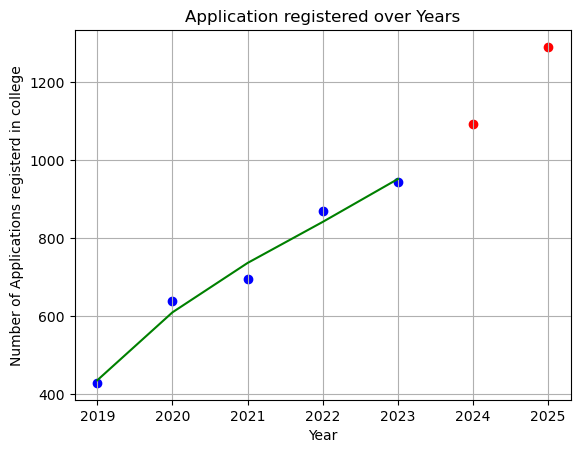

[1092.00778961 1289.8298111 ]


In [4]:
# Prediction - Polynomial fit Linear regression
from sklearn.preprocessing import PolynomialFeatures


degree = 3
# Prepare the data
X = yearly_data[['Year']]
# X = yearly_data[['Year','ApplicationSubmitted']]
# X = yearly_data[['Year','ApplicationSubmitted','StudentAdmitted']]


y = yearly_data['ApplicationSubmitted']

# Split the data
X_train = X[X['Year'].isin([2019,2020,2021,2022,2023])]
y_train = y[X['Year'].isin([2019,2020,2021,2022,2023])]

# X_train=X[~X['Year'].isin([2024, 2025])]
# y_train = y[~X['Year'].isin([2024, 2025])]
X_test=X[X['Year'].isin([2024, 2025])]

# # Fit the linear regression model
# model = LinearRegression()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# Polynomial features
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Fit the polynomial regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict the values for 2024 and 2025
y_pred = model.predict(X_test_poly)

# Plotting
plt.scatter(X_train, y_train, color='blue', label='Training Data')
plt.scatter(X_test, y_pred, color='red', label='Predicted Test Data')
plt.plot(X_train, model.predict(X_train_poly), color='green', label='Polynomial Fit')
plt.xlabel('Year')
# plt.ylabel('Number of Applications Submitted')
# plt.title('Application Submitted over Years')
plt.ylabel('Number of Applications registerd in college')
plt.title('Application registered over Years')
plt.grid(True)
plt.show()


# Create a DataFrame to display the predicted values
# predicted_data = pd.DataFrame({'Year': X_pred.flatten(), 'Predicted_ApplicationSubmitted': y_pred})
print(y_pred)

# yearly_data.loc[yearly_data['Year'] == 2024, 'StudentAdmitted'] = round(y_pred[0],0)
# yearly_data.loc[yearly_data['Year'] == 2025, 'StudentAdmitted'] = round(y_pred[1],0)
# print(yearly_data)

In [5]:
# # LOGISTIC MODEL

df['intercept'] = 1.0

# df_program = df.loc[df['MSBA'] == 1]
df_program = df
print(df_program.shape)

y=df_program['ApplicationsRegisteredinCollege']
X=df_program[['intercept', 'Age',
 'DecisionDelayDays', 'CountryUS', 'Scholarship(Yes)','Sex(Male)', 'StudentAdmitted', 'AsianIndian', 'Black/African American',
 'OtherRaces']]


# Reference Variables:
# 'Finance/Accounting' 'JointDegrees/CertificatePrograms' 'MBA'
#  'MBA/MSBAOnline' 'MBAOthers' 'MSBA'
# Student_Not_Admitted
# OtherRaces
# 2017to2020
# include 'ApplicationSubmitted', 'Application_Not_Submitted' for another model
# Sex(Male)


for column in df_program.columns:
    unique_counts = df_program[column].value_counts()
    print(f"'{column}':")
    print(unique_counts)

    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)


logit_model = sm.Logit(y_train, X_train).fit()
print(logit_model.summary())


# Prediction
y_train_pred = logit_model.predict(X_train)
y_train_pred_binary = (y_train_pred > 0.5).astype(int) 
train_conf_matrix = pd.crosstab(y_train, y_train_pred_binary, rownames=['actual'],
colnames=['predicted'])
print("Training Confusion Matrix:")
print(train_conf_matrix)
accuracy_train = accuracy_score(y_train, y_train_pred_binary)
precision_train = precision_score(y_train, y_train_pred_binary)
recall_train = recall_score(y_train, y_train_pred_binary)
print("Train Accuracy:", accuracy_train)
print("Train precision:", precision_train)
print("Train Recall:", recall_train)

y_pred = logit_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Converting probabilities to binary predictions
testing_conf_matrix = pd.crosstab(y_test,y_pred_binary,rownames
=['actual'],colnames=['predicted'])
print("Testing Confusion Matrix:")
print(testing_conf_matrix)
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
print("Test Accuracy:", accuracy)
print("Test precision:", precision)
print("Test Recall:", recall)

(7410, 63)
'referenceID':
826319459    1
632216086    1
627242092    1
627058883    1
631508120    1
            ..
274284588    1
274229068    1
261628874    1
259904697    1
999989052    1
Name: referenceID, Length: 7410, dtype: int64
'RecordCreatedDate':
10/19/2018 13:17    226
10/19/2018 13:02     53
10/19/2018 13:03     30
10/19/2018 13:04     18
10/19/2018 13:05     17
                   ... 
4/5/2023 6:52         1
9/18/2019 18:32       1
2/23/2023 5:42        1
3/8/2022 19:58        1
6/21/2020 14:57       1
Name: RecordCreatedDate, Length: 6915, dtype: int64
'PrimaryInquiryProgram':
Business Analytics - MSBA                                                1685
Business Administration (Professional) - MBA                             1351
Finance - MSF                                                            1021
Business Administration (Professional) - MBA - Online Instruction         666
Accounting and Analytics - MS                                             456
           

Training Confusion Matrix:
predicted     0    1
actual              
0          4489  316
1           215  908
Train Accuracy: 0.9104251012145749
Train precision: 0.7418300653594772
Train Recall: 0.8085485307212823
Testing Confusion Matrix:
predicted     0    1
actual              
0          1130   79
1            52  221
Test Accuracy: 0.9116059379217274
Test precision: 0.7366666666666667
Test Recall: 0.8095238095238095


Training Confusion Matrix:
predicted     0    1
actual              
0          4406  399
1           151  972
Train Accuracy: 0.9072199730094467
Train precision: 0.8379178593156751
Train Recall: 0.8912501169844784
Testing Confusion Matrix:
predicted     0    1
actual              
0          1100  109
1            39  234
Test Accuracy: 0.9001349527665317
Test precision: 0.8239875907719165
Test Recall: 0.8834928512347867


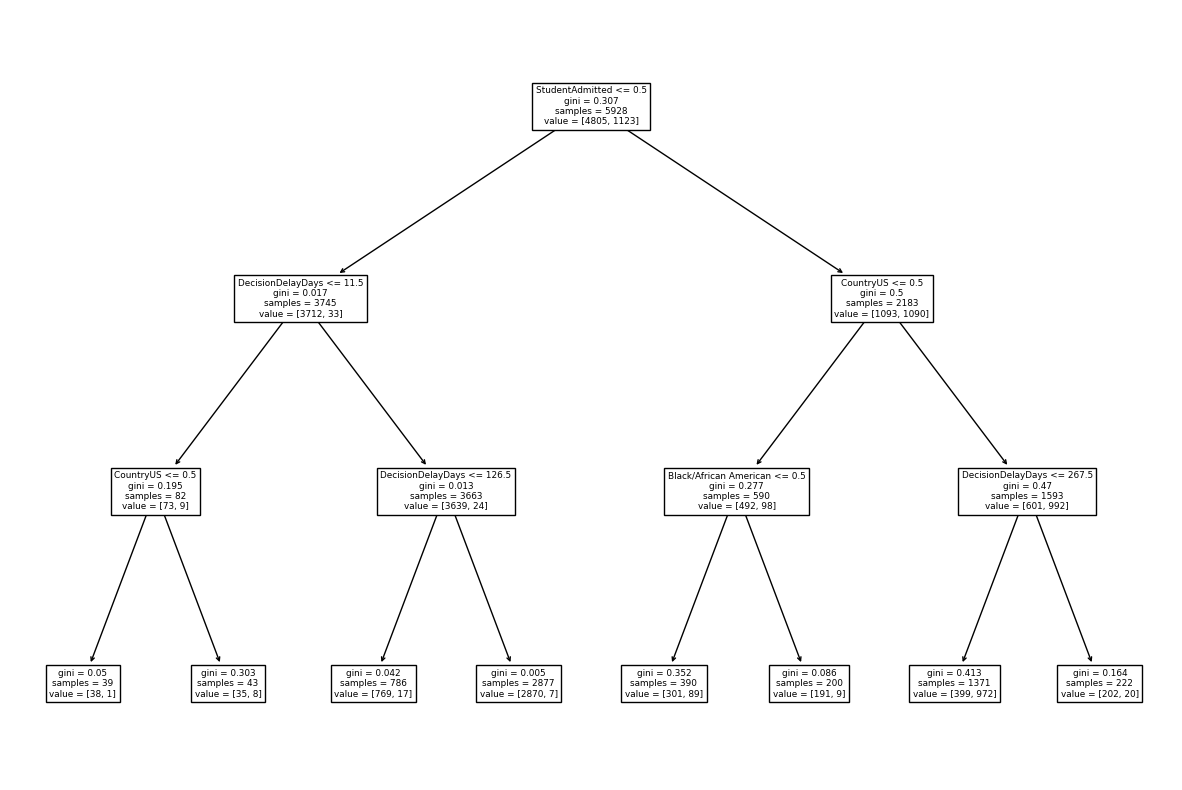

In [7]:
# DECISION TREE
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(class_weight=None, criterion='gini',
max_depth=3, max_features=None, max_leaf_nodes=None,
min_samples_leaf=10, min_samples_split=2,
min_weight_fraction_leaf=0.0, random_state=100, splitter='best')
 
# Train the classifier
clf.fit(X_train, y_train)



from sklearn import tree
plt.figure(figsize=(15, 10))
tree.plot_tree(clf, feature_names=['intercept',  'Age',
 'DecisionDelayDays', 'CountryUS', 'Scholarship(Yes)', 'Sex(Male)', 'StudentAdmitted', 'AsianIndian', 'Black/African American',
 'OtherRaces'])



# Make predictions
y_train_pred = clf.predict(X_train)
train_conf_matrix = pd.crosstab(y_train, y_train_pred, rownames=['actual'],
colnames=['predicted'])
print("Training Confusion Matrix:")
print(train_conf_matrix)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='macro')
#precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred,average='macro')
print("Train Accuracy:", accuracy_train)
print("Train precision:", precision_train)
print("Train Recall:", recall_train)

y_pred = clf.predict(X_test)
testing_conf_matrix = pd.crosstab(y_test,y_pred,rownames
=['actual'],colnames=['predicted'])
print("Testing Confusion Matrix:")
print(testing_conf_matrix)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='macro')
recall = recall_score(y_test, y_pred, average='macro')
print("Test Accuracy:", accuracy)
print("Test precision:", precision)
print("Test Recall:", recall)

In [8]:
# KNN


np.unique(y, return_counts=True)
 
# Scale the data so that no one feature gets dominated 
scaler = StandardScaler()
X = scaler.fit_transform(X)
 
# Divide the data for training and testing
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=.3, 
                                                random_state=1234, stratify=y)
 
# Make an instance of the KNeighborsClassifier class
knnc = KNeighborsClassifier()
# The default number of neighbors is 5.  Try different numbers and see how
# the different models perform. 
# knnc = KNeighborsClassifier(n_neighbors=1)
# knnc = KNeighborsClassifier(n_neighbors=5)
# knnc = KNeighborsClassifier(n_neighbors=7)
# Fit the k-nearest neighbors classifier from the training dataset.
knnc.fit(X_train, y_train)
# Make predictions using the test data
y_pred_knnc = knnc.predict(X_test)
# Build a confusion matrix and show the Classification Report
cm_knnc = confusion_matrix(y_test,y_pred_knnc)
print('\n**Confusion Matrix**\n',cm_knnc)
print('\n**Classification Report**\n')
print(classification_report(y_test,y_pred_knnc))


**Confusion Matrix**
 [[1653  151]
 [  81  338]]

**Classification Report**

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1804
           1       0.69      0.81      0.74       419

    accuracy                           0.90      2223
   macro avg       0.82      0.86      0.84      2223
weighted avg       0.90      0.90      0.90      2223



In [9]:
# LINEAR REGRESSION

from sklearn.metrics import mean_squared_error, r2_score



# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)

# Fit linear regression model
linear_model = sm.OLS(y_train, X_train).fit()

# Print summary of the model
print(linear_model.summary())

# Prediction
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training MSE:", train_mse)
print("Training R^2:", train_r2)

print("Testing MSE:", test_mse)
print("Testing R^2:", test_r2)


                                       OLS Regression Results                                       
Dep. Variable:     ApplicationsRegisteredinCollege   R-squared (uncentered):                   0.377
Model:                                         OLS   Adj. R-squared (uncentered):              0.376
Method:                              Least Squares   F-statistic:                              397.6
Date:                             Mon, 29 Apr 2024   Prob (F-statistic):                        0.00
Time:                                     22:48:36   Log-Likelihood:                         -2078.8
No. Observations:                             5928   AIC:                                      4176.
Df Residuals:                                 5919   BIC:                                      4236.
Df Model:                                        9                                                  
Covariance Type:                         nonrobust                                         

/home/prash/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


['referenceID' 'RecordCreatedDate' 'PrimaryInquiryProgram'
 'PrimaryInquiryTerm' 'ApplicationReferralSource' 'ApplicationCreatedDate'
 'ApplicationStatus' 'ApplicationProgram' 'ApplicationStartTerm'
 'DecisionsReleasedDate' 'DecisionReason' 'Country' 'State' 'VisaType'
 'PreviousDegreeInsitution' 'TestsGMATTotal' 'GPARecalculated'
 'GPAConverted' 'Age' 'Race' 'Sex' 'Intendtoapplyforfinancialaid'
 'ApplicationsRegisteredinColleague' 'ApplicationsScholarshipTierAdmit'
 'ApplicationsRegisteredinCollege' 'DecisionDelayPeriod'
 'DecisionDelayDays' 'CountryUS' 'VisaRequired' 'ApplicationStatusDecided'
 'Scholarship(Yes)' 'Sex(Male)' 'Accounting' 'Finance'
 'JointDegrees/CertificatePrograms' 'MBA' 'MBA/MSBAOnline' 'MBAOthers'
 'MSBA' 'GroupedSeason' 'Fall' 'Spring' 'Summer' 'Winter' 'Year' '2017'
 '2018' '2019' '2020' '2021' '2022' '2023' '2024' '2025'
 'ApplicationSubmitted' 'Application_Not_Submitted' 'StudentAdmitted'
 'Student_Not_Admitted' 'AsianIndian' 'Black/African American'
 'OtherRa

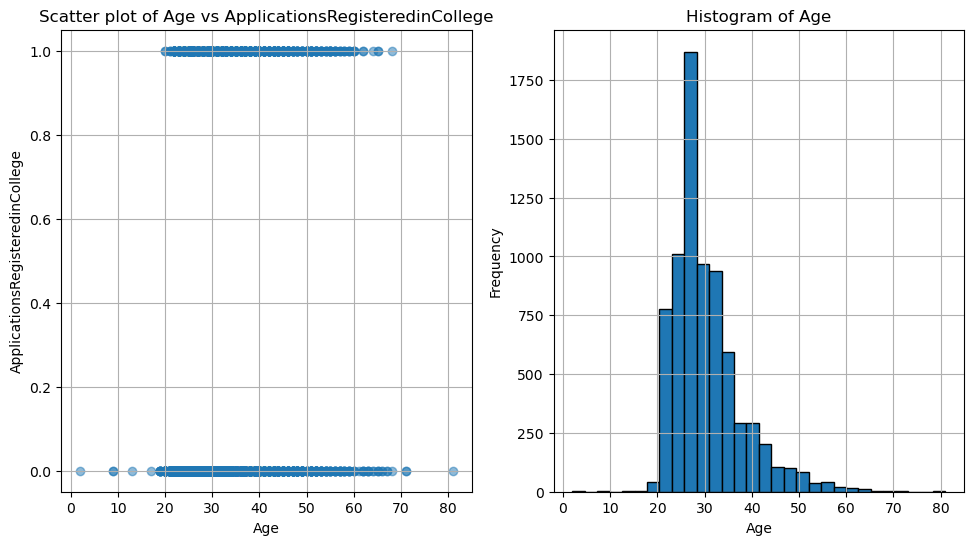

In [10]:
print(df.columns.to_numpy())

def scatter_histogram_bar(df, x_var, y_var):
    # Extract the relevant data
    x_data = df[x_var]
    y_data = df[y_var]

    # Create a scatter plot
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.scatter(x_data, y_data, alpha=0.5)
    plt.title(f'Scatter plot of {x_var} vs {y_var}')
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.grid(True)

    # Create a histogram
    plt.subplot(1, 3, 2)
    plt.hist(x_data, bins=30, edgecolor='k')
    plt.title(f'Histogram of {x_var}')
    plt.xlabel(x_var)
    plt.ylabel('Frequency')
    plt.grid(True)

 
# Example usage:
scatter_histogram_bar(df, 'Age', 'ApplicationsRegisteredinCollege')
